In [ ]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)
num_samples = 1000  # You can increase this

def generate_data(n):
    data = []
    for _ in range(n):
        gpa = np.round(np.random.normal(7.5, 0.8), 2)
        job_fit = np.round(np.random.uniform(0.4, 1.0), 2)
        resume_score = np.round(np.random.uniform(0.5, 1.0), 2)
        mentorship_count = np.random.randint(0, 6)
        projects = np.random.randint(1, 6)
        internship = np.random.choice([0, 1], p=[0.3, 0.7])
        skill_score = np.round(np.random.uniform(0.5, 1.0), 2)
        soft_skills = np.round(np.random.uniform(0.4, 1.0), 2)
        referrer_trust = np.round(np.random.uniform(0.5, 1.0), 2)

        # Weighted formula to determine if hired
        weighted_sum = (
            0.15 * gpa +
            0.25 * job_fit +
            0.2 * resume_score +
            0.1 * mentorship_count +
            0.05 * projects +
            0.1 * internship +
            0.05 * skill_score +
            0.05 * soft_skills +
            0.05 * referrer_trust
        )
        hired = 1 if weighted_sum > 1.9 else 0

        data.append([
            gpa, job_fit, resume_score, mentorship_count, projects,
            internship, skill_score, soft_skills, referrer_trust, hired
        ])
    return pd.DataFrame(data, columns=[
        "gpa", "job_fit", "resume_score", "mentorship_count", "projects",
        "internship", "skill_score", "soft_skills", "referrer_trust", "hired"
    ])

# Generate and save
df = generate_data(num_samples)
df.to_csv("referral_data.csv", index=False)
print("✅ referral_data.csv saved!")

# Show sample
df.head()


✅ referral_data.csv saved!


,gpa,job_fit,resume_score,mentorship_count,projects,internship,skill_score,soft_skills,referrer_trust,hired
0,7.90,0.84,0.80,1,3,0,0.73,0.60,0.57,1
1,7.39,0.79,0.53,3,2,0,0.59,0.58,0.76,1
2,6.12,0.77,0.57,3,4,1,0.73,0.87,0.60,1
3,7.05,0.71,0.80,2,5,1,0.59,0.44,0.97,1
4,7.02,0.81,0.72,3,5,1,0.59,0.63,0.59,1


In [ ]:
from google.colab import files
files.download("referral_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Accuracy: 0.985

📊 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        69
           1       0.98      1.00      0.99       131

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



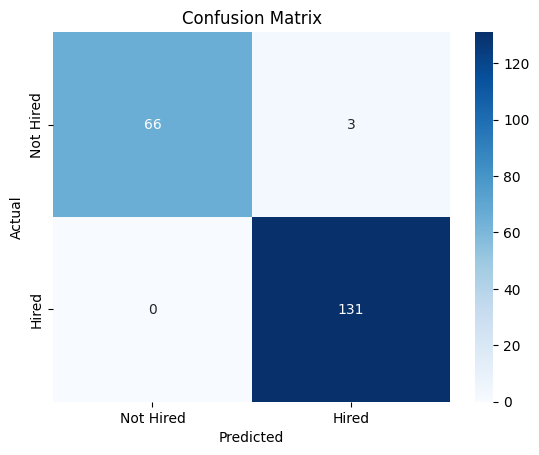

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv("referral_data.csv")

# Features and target
X = df.drop("hired", axis=1)
y = df["hired"]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)
y_prob = model.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Hired", "Hired"], yticklabels=["Not Hired", "Hired"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import joblib

joblib.dump(model, "referral_model.pkl")
joblib.dump(scaler, "scaler.pkl")
print("✅ Model and Scaler saved!")


✅ Model and Scaler saved!


In [ ]:
!pip install pymupdf joblib

import fitz  # PyMuPDF
import re
import pandas as pd
import joblib
from google.colab import files

# Upload the resume
uploaded = files.upload()
resume_file = list(uploaded.keys())[0]

# Extract text from PDF
with fitz.open(resume_file) as doc:
    resume_text = "\n".join([page.get_text() for page in doc])

# Feature Extraction (basic)
def extract_features(text):
    gpa_match = re.findall(r"(\d\.\d+)\s*/\s*10", text)
    gpa = float(gpa_match[0]) if gpa_match else 7.5  # default

    internship = 1 if "intern" in text.lower() else 0
    projects = text.lower().count("project")  # rough estimate

    skills = re.findall(r"skills[:\-]?\s*(.*)", text, re.IGNORECASE)
    skill_list = skills[0].split(",") if skills else []
    skill_score = min(len(skill_list)/10, 1.0)

    soft_skills = 0.7  # placeholder (can use LLM later)
    mentorship_count = 2  # from platform data later
    referrer_trust = 0.9  # from blockchain later
    job_fit = 0.75  # from JD similarity later
    resume_score = 0.8  # from NLP model later

    return {
        "gpa": gpa,
        "job_fit": job_fit,
        "resume_score": resume_score,
        "mentorship_count": mentorship_count,
        "projects": projects,
        "internship": internship,
        "skill_score": round(skill_score, 2),
        "soft_skills": soft_skills,
        "referrer_trust": referrer_trust
    }

# Extracted features
features = extract_features(resume_text)
input_df = pd.DataFrame([features])

# Load model + scaler
model = joblib.load("referral_model.pkl")
scaler = joblib.load("scaler.pkl")

# Predict
scaled_input = scaler.transform(input_df)
success_prob = model.predict_proba(scaled_input)[0][1]

print("🔍 Extracted Features:")
print(input_df)
print(f"\n🎯 Success Probability: {round(success_prob, 2)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 54.6 MB/s eta 0:00:00


Saving Monish_Kumar_A_IT.pdf to Monish_Kumar_A_IT.pdf
🔍 Extracted Features:
    gpa  job_fit  resume_score  mentorship_count  projects  internship  \
0  8.08     0.75           0.8                 2         2           1   

   skill_score  soft_skills  referrer_trust  
0          0.5          0.7             0.9  

🎯 Success Probability: 1.0


In [ ]:
# Enter role manually (later you can convert to dropdown)
target_role = input("Enter the target job role (e.g., Data Analyst): ").strip().lower()

# Function to calculate job fit score based on role keywords
def compute_job_fit_score(text, role):
    role_keywords = {
        "data analyst": ["python", "excel", "sql", "power bi", "statistics", "pandas"],
        "frontend developer": ["html", "css", "javascript", "react", "angular"],
        "backend developer": ["node.js", "express", "java", "python", "api", "sql"],
        "ml engineer": ["machine learning", "tensorflow", "scikit", "pytorch", "model"],
        "devops": ["docker", "kubernetes", "ci/cd", "aws", "linux"]
    }

    text_lower = text.lower()
    keywords = role_keywords.get(role, [])
    if not keywords:
        return 0.5  # Neutral fit

    match_count = sum(1 for kw in keywords if kw in text_lower)
    return round(match_count / len(keywords), 2)

# Update extract_features function to include role
def extract_features_with_role(text, role):
    gpa_match = re.findall(r"(\d\.\d+)\s*/\s*10", text)
    gpa = float(gpa_match[0]) if gpa_match else 7.5

    internship = 1 if "intern" in text.lower() else 0
    projects = text.lower().count("project")
    skills = re.findall(r"skills[:\-]?\s*(.*)", text, re.IGNORECASE)
    skill_list = skills[0].split(",") if skills else []
    skill_score = min(len(skill_list)/10, 1.0)

    soft_skills = 0.7
    mentorship_count = 2
    referrer_trust = 0.9
    resume_score = 0.8
    job_fit = compute_job_fit_score(text, role)

    return {
        "gpa": gpa,
        "job_fit": job_fit,
        "resume_score": resume_score,
        "mentorship_count": mentorship_count,
        "projects": projects,
        "internship": internship,
        "skill_score": round(skill_score, 2),
        "soft_skills": soft_skills,
        "referrer_trust": referrer_trust
    }

# Extract features with role-specific job fit
features = extract_features_with_role(resume_text, target_role)
input_df = pd.DataFrame([features])

# Load model + scaler
scaled_input = scaler.transform(input_df)
success_prob = model.predict_proba(scaled_input)[0][1]

print("🔍 Extracted Features with Role:", target_role)
print(input_df)
print(f"\n🎯 Success Probability for role '{target_role}': {round(success_prob, 2)}")


Enter the target job role (e.g., Data Analyst): backend developer
🔍 Extracted Features with Role: backend developer
    gpa  job_fit  resume_score  mentorship_count  projects  internship  \
0  8.08     0.83           0.8                 2         2           1   

   skill_score  soft_skills  referrer_trust  
0          0.5          0.7             0.9  

🎯 Success Probability for role 'backend developer': 1.0
